22:06:44 - cmdstanpy - INFO - Chain [1] start processing
22:06:44 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

Searching best ARIMA parameters based on AIC
 Best ARIMA order: (3, 1, 3) with AIC: 3852.29

--- Forecast Accuracy Comparison ---
     Model       RMSE        MAE  MAPE
0  Prophet  203130.70  165067.38  6.23
1     LSTM  324658.35  273489.57  9.73
2    ARIMA  347567.08  284211.08  9.95

 Best Model Based on RMSE: Prophet


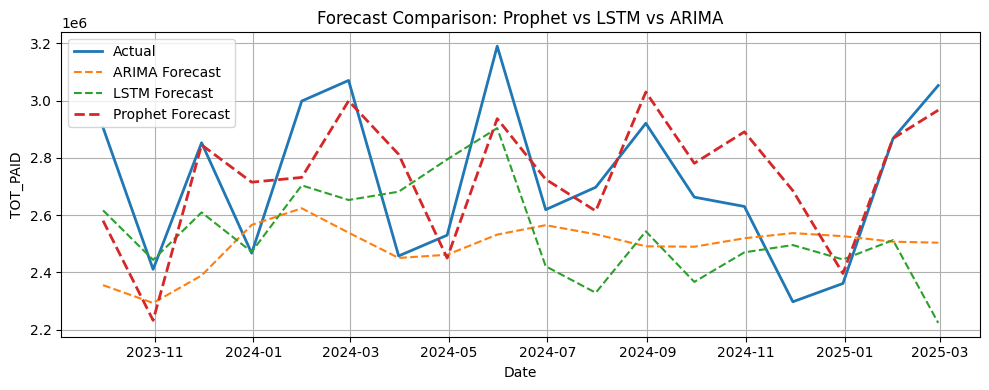

In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



# Load dataset
df = pd.read_csv("C:/GitHub/Machine-Learning/data/Payment Data.csv")
df['ACC_MONTH'] = pd.to_datetime(df['ACC_MONTH'])
df = df[['ACC_MONTH', 'TOT_PAID', 'EST_COST', 'NBR_CASE', 'NBR_KEY_CASE', 'NBR_OTHER']].dropna()
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
df = df.sort_values('ds').reset_index(drop=True)

# --- Lagged Regressors ---
lag = 12
regressors = ['EST_COST', 'NBR_OTHER']
for reg in regressors:
    df[f'{reg}_lag{lag}'] = df[reg].shift(lag)
df_model = df.dropna().copy().reset_index(drop=True)

# --- PCA on Lagged Regressors ---
lagged_features = [f'{reg}_lag{lag}' for reg in regressors]
X_lagged = StandardScaler().fit_transform(df_model[lagged_features])
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_lagged)
df_model['PC1'] = pcs[:, 0]
df_model['PC2'] = pcs[:, 1]

# Fitting three time series models and measuing their accuracy for comparison
################# 1. Prophet Model ############################

train = df_model[:-18]
test = df_model[-18:]

prophet_model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.2)
prophet_model.add_regressor('PC1')
prophet_model.add_regressor('PC2')
prophet_model.fit(train[['ds', 'y', 'PC1', 'PC2']])
forecast_test = prophet_model.predict(test[['ds', 'PC1', 'PC2']])

# Prophet evaluation
prophet_rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
prophet_mae = mean_absolute_error(test['y'], forecast_test['yhat'])

actual = test['y'].values
predicted = forecast_test['yhat'].values
nonzero_mask = actual != 0
actual_nonzero = actual[nonzero_mask]
predicted_nonzero = predicted[nonzero_mask]
prophet_mape = np.mean(np.abs((actual_nonzero - predicted_nonzero) / actual_nonzero)) * 100 if len(actual_nonzero) > 0 else np.nan


################## 2. LSTM Model ##########################

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_all = feature_scaler.fit_transform(df_model[['PC1', 'PC2']])
y_all = target_scaler.fit_transform(df_model[['TOT_PAID']])

time_steps = 12 #12 step learning sequence because we know our data has annual seasonality. 
X_seq, y_seq = [], []
for i in range(len(X_all) - time_steps):
    X_seq.append(X_all[i:i+time_steps])
    y_seq.append(y_all[i+time_steps])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

split = len(X_seq) - 18
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
# we use sequential layering here because we want one layer output to be considered as the next layer's input as a classing time series forecasting trend
# we use relue becuase our target value data are expenditures and above zero
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dense(1)
])

# we use Adam optimizer for faster processing
# step size = 0.001 as the learning rate which is good enough for this model search task
# and use Mean Square Error mae as the loss funtion in our sequential LSTM model
# verbose is set to 0 to suppress the training logs

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') 
model.fit(X_train, y_train, epochs=100, verbose=0)

y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test)

lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
lstm_mae = mean_absolute_error(y_test_inv, y_pred_inv)
lstm_mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100


################# 3. ARIMA Model with AIC Optimization #################

# defines tha last 1 and 1/2 year data for the testing the model
arima_train = df_model['TOT_PAID'][:-18]
arima_test = df_model['TOT_PAID'][-18:]

# Grid search for best ARIMA order we use Akaike Information Criterion (AIC) to search for the best model with minimum AIC
best_aic = np.inf
best_order = None
best_model = None

print("\nSearching best ARIMA parameters based on AIC")
# reasonable range for parameters in ARIMA model is less than 4

for p in range(0, 4):                           
    for d in range(0, 2):               # Differential parameter range is usually set to half of the max of P or Q which are 4 here
        for q in range(0, 4):
            try:
                model = ARIMA(arima_train, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
            except:
                continue

print(f" Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")

# Forecast using best model
arima_forecast = best_model.forecast(steps=18)

arima_rmse = np.sqrt(mean_squared_error(arima_test, arima_forecast))
arima_mae = mean_absolute_error(arima_test, arima_forecast)
arima_mape = np.mean(np.abs((arima_test - arima_forecast) / arima_test)) * 100



############ Compare Models ###################

results = pd.DataFrame({
    'Model': ['Prophet', 'LSTM', 'ARIMA'],
    'RMSE': [prophet_rmse, lstm_rmse, arima_rmse],
    'MAE': [prophet_mae, lstm_mae, arima_mae],
    'MAPE': [prophet_mape, lstm_mape, arima_mape]
    
})

best_model = results.loc[results['MAPE'].idxmin()]

print("\n--- Forecast Accuracy Comparison ---")
print(results.round(2))
print(f"\n Best Model Based on RMSE: {best_model['Model']}")


############## plto the results ############################

test_dates = df_model['ds'][-18:].reset_index(drop=True)

plt.figure(figsize=(10, 4))
plt.plot(test_dates, arima_test.values, label='Actual', linewidth=2)
plt.plot(test_dates, arima_forecast.values, label='ARIMA Forecast', linestyle='--')
plt.plot(test_dates, y_pred_inv.flatten(), label='LSTM Forecast', linestyle='--')
plt.plot(test_dates, forecast_test['yhat'].values, label='Prophet Forecast', linestyle='--',linewidth = 2)

plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.title("Forecast Comparison: Prophet vs LSTM vs ARIMA")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.xticks(rotation=45)
plt.show()